In [ ]:
#Want to look at the possible correlations or trends to see if we can model predictions for outages to better prepare.

In [1]:
#Import libraries for EDA and data

import numpy as np
import pandas as pd

outage_df=pd.read_csv('NoNeg_outagedata.csv')

In [2]:
outage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Event Description             1609 non-null   object
 1   Year                          1609 non-null   int64 
 2   Date Event Began              1609 non-null   object
 3   Time Event Began              1600 non-null   object
 4   Date of Restoration           1599 non-null   object
 5   Time of Restoration           1568 non-null   object
 6   Respondent                    1609 non-null   object
 7   Geographic Areas              1609 non-null   object
 8   NERC Region                   1607 non-null   object
 9   Demand Loss (MW)              1214 non-null   object
 10  Number of Customers Affected  1397 non-null   object
 11  Tags                          1608 non-null   object
 12  Event Start                   1600 non-null   object
 13  Event End         

In [3]:
df_cleaned = outage_df.dropna(subset=['Date Event Began', 'Time Event Began', 'Date of Restoration'])


In [4]:
df_cleaned.loc[:, 'Time Event Began'] = df_cleaned['Time Event Began'].fillna('00:00:00')
df_cleaned.loc[:, 'Time of Restoration'] = df_cleaned['Time of Restoration'].fillna('00:00:00')
df_cleaned.loc[:, 'NERC Region'] = df_cleaned['NERC Region'].fillna('Unknown')
df_cleaned.loc[:, 'Demand Loss (MW)'] = df_cleaned['Demand Loss (MW)'].fillna('0')
df_cleaned.loc[:, 'Number of Customers Affected'] = df_cleaned['Number of Customers Affected'].fillna('0')


In [5]:
df_cleaned.loc[:, 'Date Event Began'] = pd.to_datetime(df_cleaned['Date Event Began'])
df_cleaned.loc[:, 'Time Event Began'] = pd.to_datetime(df_cleaned['Time Event Began'], format='%H:%M:%S').dt.time
df_cleaned.loc[:, 'Date of Restoration'] = pd.to_datetime(df_cleaned['Date of Restoration'])
df_cleaned.loc[:, 'Time of Restoration'] = pd.to_datetime(df_cleaned['Time of Restoration'], format='%H:%M:%S').dt.time



In [8]:
from datetime import datetime

# Convert and combine date and time columns
df_cleaned.loc[:, 'Event Start Date'] = pd.to_datetime(df_cleaned['Date Event Began'], format='%Y-%m-%d', errors='coerce')
df_cleaned.loc[:, 'Event Start Time'] = pd.to_datetime(df_cleaned['Time Event Began'], format='%H:%M:%S', errors='coerce').dt.time

# Combine date and time into a single datetime column
df_cleaned.loc[:, 'Event Start'] = df_cleaned.apply(
    lambda row: datetime.combine(row['Event Start Date'], row['Event Start Time']) if pd.notnull(row['Event Start Date']) and pd.notnull(row['Event Start Time']) else pd.NaT,
    axis=1
)

# Repeat for Event End
df_cleaned.loc[:, 'Event End Date'] = pd.to_datetime(df_cleaned['Date of Restoration'], format='%Y-%m-%d', errors='coerce')
df_cleaned.loc[:, 'Event End Time'] = pd.to_datetime(df_cleaned['Time of Restoration'], format='%H:%M:%S', errors='coerce').dt.time

df_cleaned.loc[:, 'Event End'] = df_cleaned.apply(
    lambda row: datetime.combine(row['Event End Date'], row['Event End Time']) if pd.notnull(row['Event End Date']) and pd.notnull(row['Event End Time']) else pd.NaT,
    axis=1
)


In [9]:
df_cleaned.loc[:, 'Duration'] = pd.to_timedelta(df_cleaned['Duration']).dt.total_seconds() / 3600  # Convert to hours


In [10]:
df_cleaned.loc[:, 'Demand Loss (MW)'] = pd.to_numeric(df_cleaned['Demand Loss (MW)'], errors='coerce')
df_cleaned.loc[:, 'Number of Customers Affected'] = pd.to_numeric(df_cleaned['Number of Customers Affected'], errors='coerce')


In [11]:
print(df_cleaned.dtypes)

Event Description                       object
Year                                     int64
Date Event Began                        object
Time Event Began                        object
Date of Restoration                     object
Time of Restoration                     object
Respondent                              object
Geographic Areas                        object
NERC Region                             object
Demand Loss (MW)                        object
Number of Customers Affected            object
Tags                                    object
Event Start                     datetime64[ns]
Event End                       datetime64[ns]
Duration                                object
Is Negative                               bool
Event Start Date                datetime64[ns]
Event Start Time                        object
Event End Date                  datetime64[ns]
Event End Time                          object
dtype: object


In [12]:
# Check for negative durations
df_cleaned['Is Negative'] = df_cleaned['Duration'] < 0

# Drop rows with negative durations if needed
df_cleaned = df_cleaned[~df_cleaned['Is Negative']]

print(df_cleaned)

                   Event Description  Year     Date Event Began  \
0     Severe Weather - Thunderstorms  2014  2014-06-30 00:00:00   
1     Severe Weather - Thunderstorms  2014  2014-06-30 00:00:00   
2     Severe Weather - Thunderstorms  2014  2014-06-30 00:00:00   
3        Physical Attack - Vandalism  2014  2014-06-24 00:00:00   
4        Physical Attack - Vandalism  2014  2014-06-19 00:00:00   
...                              ...   ...                  ...   
1604                  Severe Weather  2000  2000-05-02 00:00:00   
1605          Transmission Line Loss  2000  2000-03-18 00:00:00   
1606          Transmission Line Loss  2000  2000-03-18 00:00:00   
1607                       Ice Storm  2000  2000-01-29 00:00:00   
1608                       Ice Storm  2000  2000-01-23 00:00:00   

     Time Event Began  Date of Restoration Time of Restoration  \
0            20:00:00  2014-07-02 00:00:00            18:30:00   
1            23:20:00  2014-07-01 00:00:00            17:00:00 

C:\Users\hmkfs\AppData\Local\Temp\ipykernel_2252\1962420292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Is Negative'] = df_cleaned['Duration'] < 0


In [13]:
print(df_cleaned.describe(include='all'))

       Event Description         Year     Date Event Began Time Event Began  \
count               1592  1592.000000                 1592             1592   
unique               283          NaN                  990              638   
top       Severe Weather          NaN  2012-10-29 00:00:00         16:00:00   
freq                 156          NaN                   24               39   
mean                 NaN  2009.351759                  NaN              NaN   
min                  NaN  2000.000000                  NaN              NaN   
25%                  NaN  2007.000000                  NaN              NaN   
50%                  NaN  2010.000000                  NaN              NaN   
75%                  NaN  2012.000000                  NaN              NaN   
max                  NaN  2014.000000                  NaN              NaN   
std                  NaN     3.404900                  NaN              NaN   

        Date of Restoration Time of Restoration    

C:\Users\hmkfs\AppData\Local\Temp\ipykernel_2252\1929198989.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  print(df_cleaned.describe(include='all'))
C:\Users\hmkfs\AppData\Local\Temp\ipykernel_2252\1929198989.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  print(df_cleaned.describe(include='all'))


In [14]:
outage_df.head()

,Event Description,Year,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Respondent,Geographic Areas,NERC Region,Demand Loss (MW),Number of Customers Affected,Tags,Event Start,Event End,Duration,Is Negative
0,Severe Weather - Thunderstorms,2014,2014-06-30,20:00:00,2014-07-02,18:30:00,Exelon Corporation/ComEd,Illinois,RFC,Unknown,"420,000","severe weather, thunderstorm",2014-06-30 20:00:00,2014-07-02 18:30:00,1 days 22:30:00,False
1,Severe Weather - Thunderstorms,2014,2014-06-30,23:20:00,2014-07-01,17:00:00,Northern Indiana Public Service Company,North Central Indiana,RFC,Unknown,"127,000","severe weather, thunderstorm",2014-06-30 23:20:00,2014-07-01 17:00:00,0 days 17:40:00,False
2,Severe Weather - Thunderstorms,2014,2014-06-30,17:55:00,2014-07-01,02:53:00,We Energies,Southeast Wisconsin,MRO,424,"120,000","severe weather, thunderstorm",2014-06-30 17:55:00,2014-07-01 02:53:00,0 days 08:58:00,False
3,Physical Attack - Vandalism,2014,2014-06-24,14:54:00,2014-06-24,14:55:00,Tennessee Valley Authority,"Nashville, Tennessee",SERC,Unknown,Unknown,"vandalism, physical",2014-06-24 14:54:00,2014-06-24 14:55:00,0 days 00:01:00,False
4,Physical Attack - Vandalism,2014,2014-06-19,08:47:00,2014-06-19,08:48:00,Tennessee Valley Authority,"Nashville, Tennessee",SERC,Unknown,Unknown,"vandalism, physical",2014-06-19 08:47:00,2014-06-19 08:48:00,0 days 00:01:00,False


In [15]:
#drop is negative
outage_df = outage_df.drop(columns=['Is Negative'])

In [16]:
outage_df.head()

,Event Description,Year,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Respondent,Geographic Areas,NERC Region,Demand Loss (MW),Number of Customers Affected,Tags,Event Start,Event End,Duration
0,Severe Weather - Thunderstorms,2014,2014-06-30,20:00:00,2014-07-02,18:30:00,Exelon Corporation/ComEd,Illinois,RFC,Unknown,"420,000","severe weather, thunderstorm",2014-06-30 20:00:00,2014-07-02 18:30:00,1 days 22:30:00
1,Severe Weather - Thunderstorms,2014,2014-06-30,23:20:00,2014-07-01,17:00:00,Northern Indiana Public Service Company,North Central Indiana,RFC,Unknown,"127,000","severe weather, thunderstorm",2014-06-30 23:20:00,2014-07-01 17:00:00,0 days 17:40:00
2,Severe Weather - Thunderstorms,2014,2014-06-30,17:55:00,2014-07-01,02:53:00,We Energies,Southeast Wisconsin,MRO,424,"120,000","severe weather, thunderstorm",2014-06-30 17:55:00,2014-07-01 02:53:00,0 days 08:58:00
3,Physical Attack - Vandalism,2014,2014-06-24,14:54:00,2014-06-24,14:55:00,Tennessee Valley Authority,"Nashville, Tennessee",SERC,Unknown,Unknown,"vandalism, physical",2014-06-24 14:54:00,2014-06-24 14:55:00,0 days 00:01:00
4,Physical Attack - Vandalism,2014,2014-06-19,08:47:00,2014-06-19,08:48:00,Tennessee Valley Authority,"Nashville, Tennessee",SERC,Unknown,Unknown,"vandalism, physical",2014-06-19 08:47:00,2014-06-19 08:48:00,0 days 00:01:00


In [17]:
#update duration to numeric
#  Function to convert 'X days XX:XX:XX' to total hours, with handling for NaN or missing values
def convert_duration_to_hours(duration):
    if isinstance(duration, str):  # Check if the value is a string
        days, time_str = duration.split(" days ")
        hours, minutes, seconds = map(int, time_str.split(":"))
        total_hours = int(days) * 24 + hours + minutes / 60 + seconds / 3600
        return total_hours
    else:
        return None  # Handle NaN or invalid values

# Apply the conversion to the Duration column
outage_df['Duration (Hours)'] = outage_df['Duration'].apply(convert_duration_to_hours)


In [18]:
outage_df['Duration'].describe()

count                1560
unique                887
top       0 days 00:01:00
freq                   82
Name: Duration, dtype: object

In [19]:
print(outage_df.head())

                Event Description  Year Date Event Began Time Event Began  \
0  Severe Weather - Thunderstorms  2014       2014-06-30         20:00:00   
1  Severe Weather - Thunderstorms  2014       2014-06-30         23:20:00   
2  Severe Weather - Thunderstorms  2014       2014-06-30         17:55:00   
3     Physical Attack - Vandalism  2014       2014-06-24         14:54:00   
4     Physical Attack - Vandalism  2014       2014-06-19         08:47:00   

  Date of Restoration Time of Restoration  \
0          2014-07-02            18:30:00   
1          2014-07-01            17:00:00   
2          2014-07-01            02:53:00   
3          2014-06-24            14:55:00   
4          2014-06-19            08:48:00   

                                Respondent       Geographic Areas NERC Region  \
0                 Exelon Corporation/ComEd               Illinois         RFC   
1  Northern Indiana Public Service Company  North Central Indiana         RFC   
2                      

In [20]:
outage_df['Respondent'].value_counts()
outage_df['Event Description'].value_counts()

Event Description
Severe Weather                                            157
Vandalism                                                 118
Severe Thunderstorms                                       82
Suspected Physical Attack                                  79
Physical Attack - Vandalism                                78
                                                         ... 
Major System Interruption/Load Shed                         1
Declared Energy Emergency Alert 1/Heat wave                 1
Actual Physical Attack                                      1
Electrical Separation/Load Shedding/Made Public Appeal      1
Equipment Failure/Made Public Appeal                        1
Name: count, Length: 284, dtype: int64

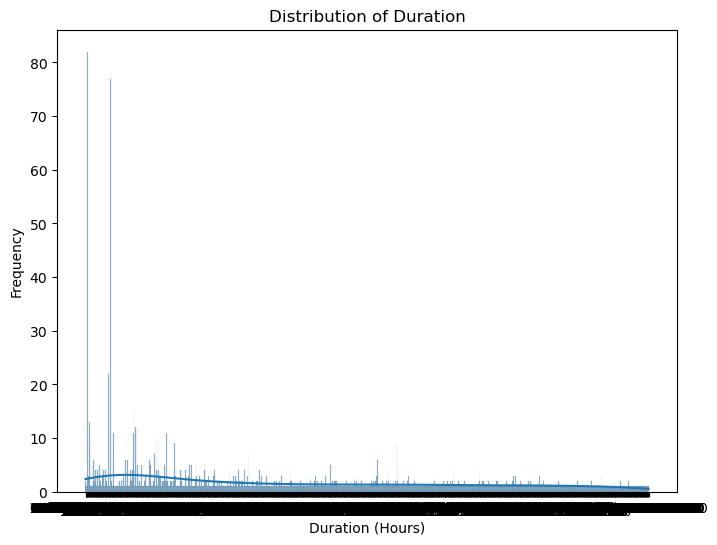

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Duration
plt.figure(figsize=(8,6))
sns.histplot(outage_df['Duration'], bins=20, kde=True)
plt.title('Distribution of Duration')
plt.xlabel('Duration (Hours)')
plt.ylabel('Frequency')
plt.show()

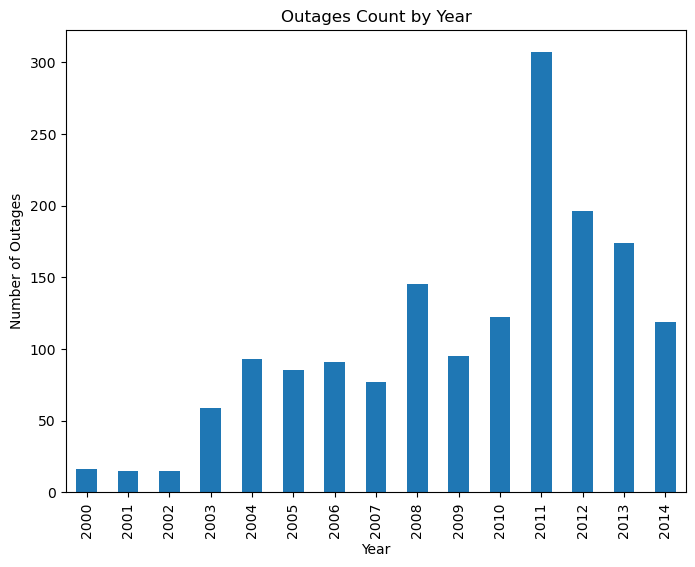

In [22]:
#event count by year
plt.figure(figsize=(8,6))
outage_df['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Outages Count by Year')
plt.xlabel('Year')
plt.ylabel('Number of Outages')
plt.show()

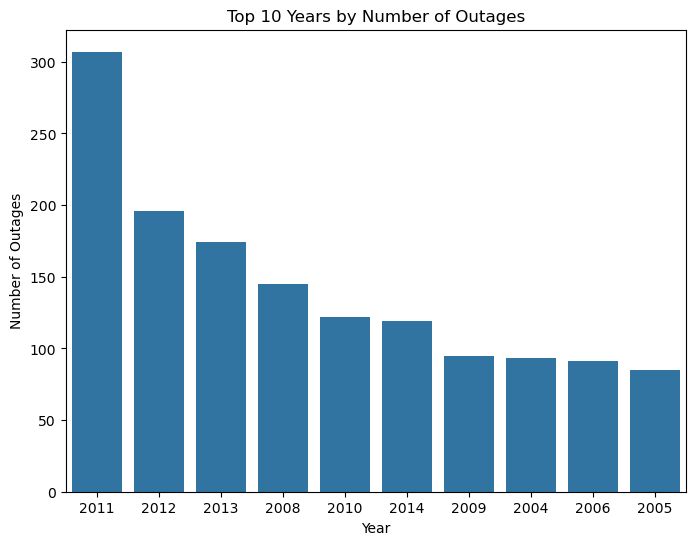

In [23]:
# Get the top 10 years by the number of outages
top_10_years = outage_df['Year'].value_counts().nlargest(10).index

# Filter the DataFrame to include only those years
top_years_data = outage_df[outage_df['Year'].isin(top_10_years)]

# Plot the number of outages by year (only the top 10)
plt.figure(figsize=(8,6))
sns.countplot(x='Year', data=top_years_data, order=top_10_years)
plt.title('Top 10 Years by Number of Outages')
plt.xlabel('Year')
plt.ylabel('Number of Outages')
plt.show()


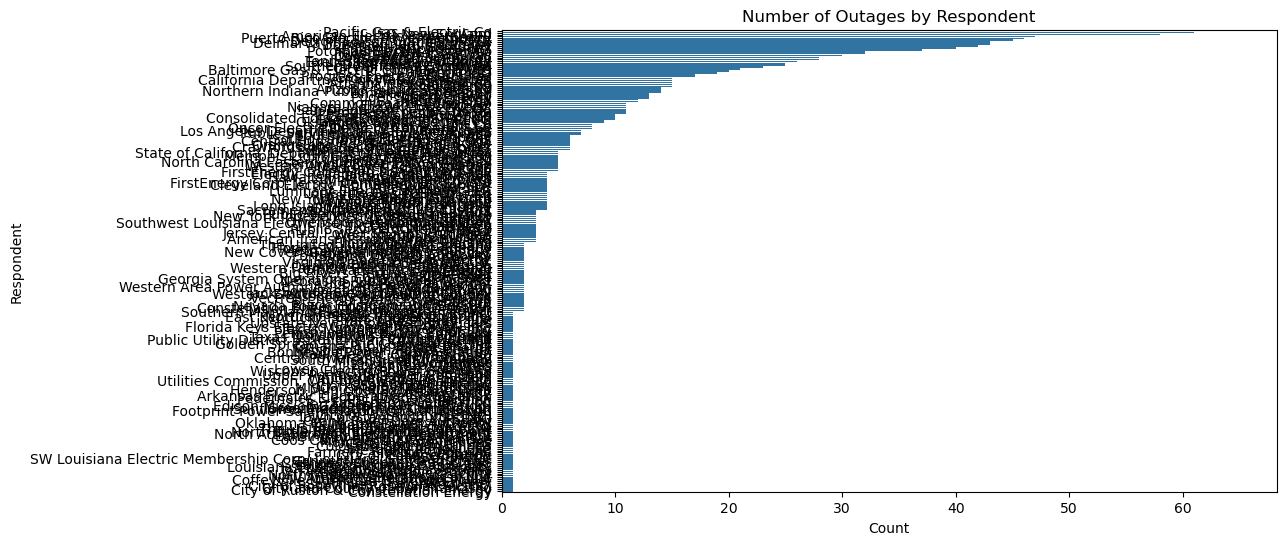

In [24]:
#outage by respondent
plt.figure(figsize=(10,6))
sns.countplot(y='Respondent', data=outage_df, order=outage_df['Respondent'].value_counts().index)
plt.title('Number of Outages by Respondent')
plt.xlabel('Count')
plt.ylabel('Respondent')
plt.show()

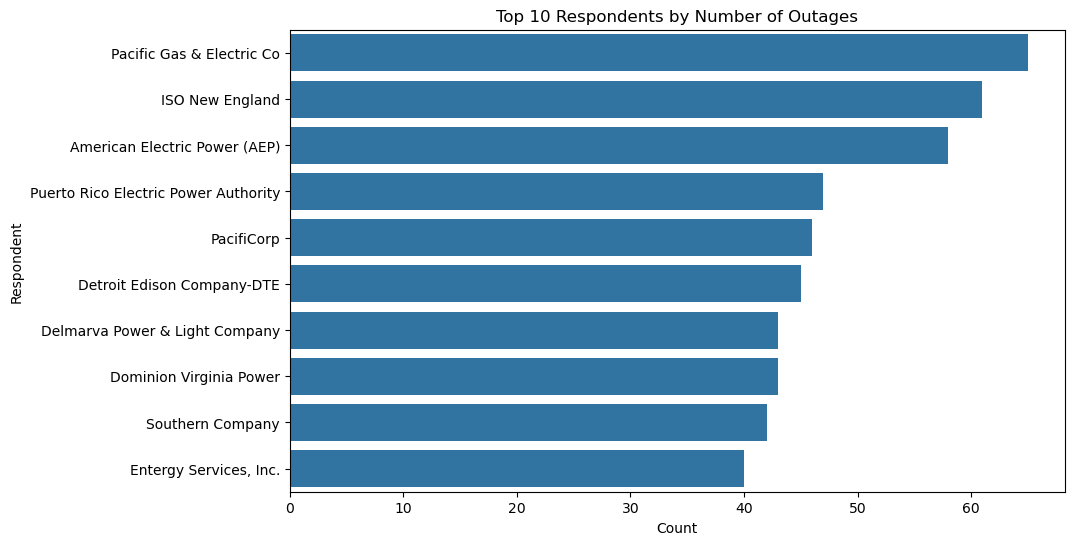

In [25]:
# Get the top 10 respondents by the number of outages
top_10_respondents = outage_df['Respondent'].value_counts().nlargest(10).index

# Filter the DataFrame to include only those respondents
top_respondents_data = outage_df[outage_df['Respondent'].isin(top_10_respondents)]

# Plot the number of outages by respondent (only the top 10)
plt.figure(figsize=(10,6))
sns.countplot(y='Respondent', data=top_respondents_data, order=top_10_respondents)
plt.title('Top 10 Respondents by Number of Outages')
plt.xlabel('Count')
plt.ylabel('Respondent')
plt.show()


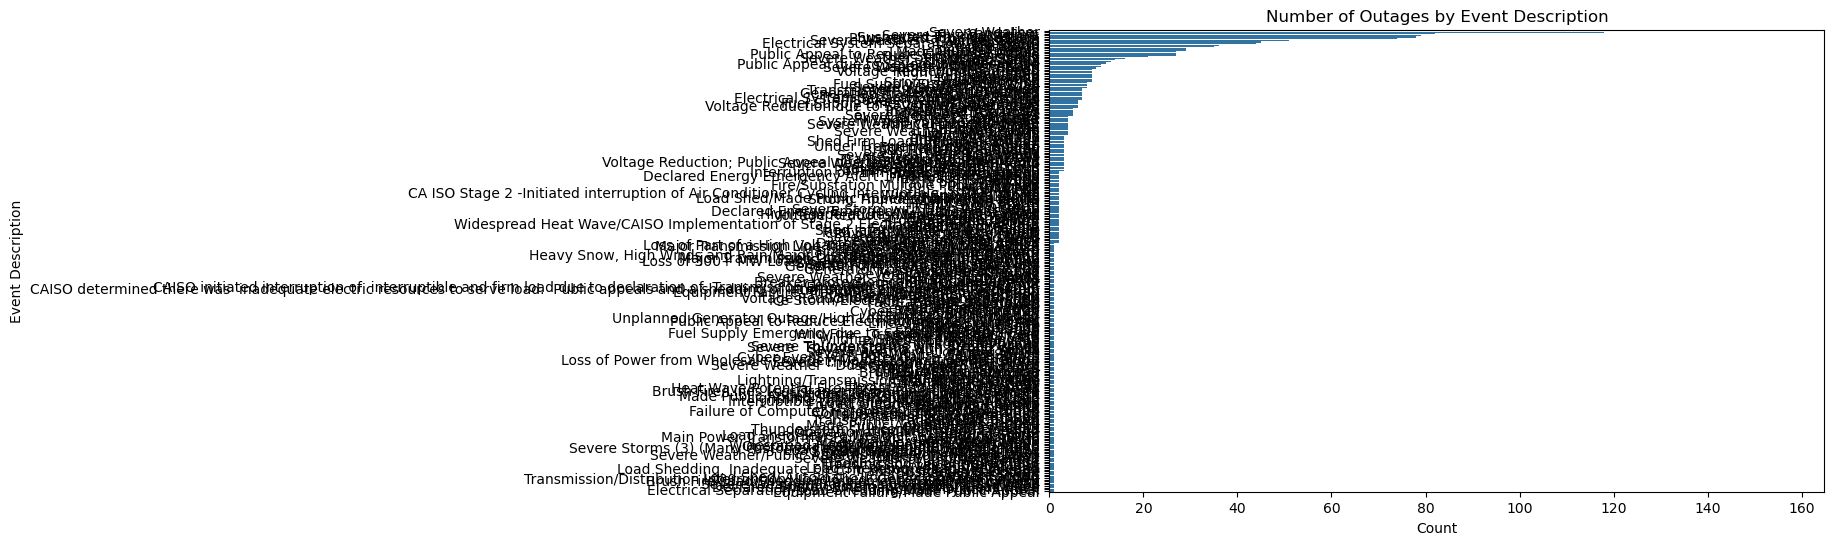

In [26]:
#outages by Event Description
plt.figure(figsize=(10,6))
sns.countplot(y='Event Description', data=outage_df, order=outage_df['Event Description'].value_counts().index)
plt.title('Number of Outages by Event Description')
plt.xlabel('Count')
plt.ylabel('Event Description')
plt.show()


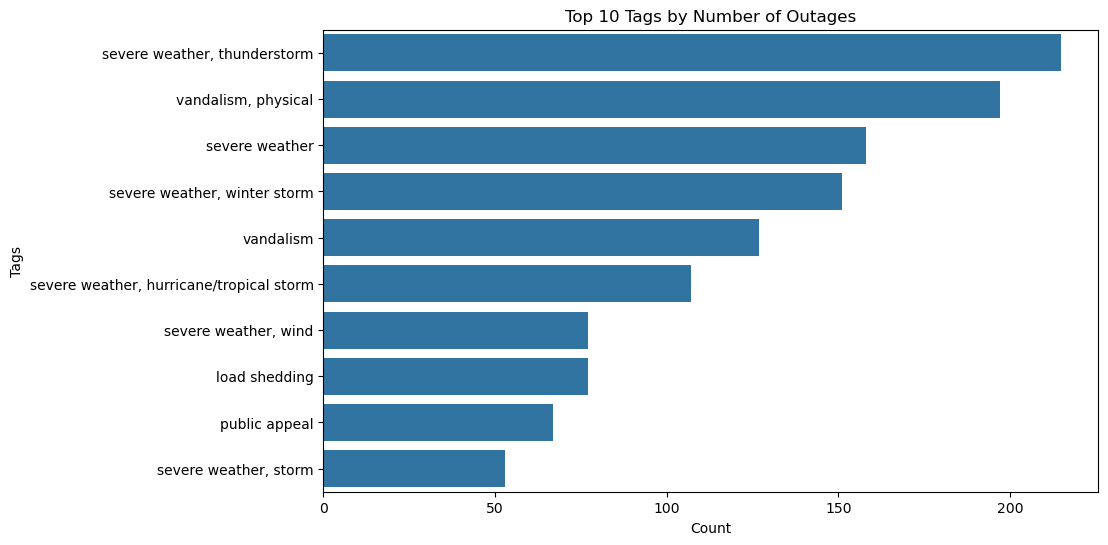

In [27]:
# Get the top 10 tags by the number of outages
top_10_tags = outage_df['Tags'].value_counts().nlargest(10).index

# Filter the DataFrame to include only those tags
top_tags_data = outage_df[outage_df['Tags'].isin(top_10_tags)]

# Plot the number of outages by tag (only the top 10)
plt.figure(figsize=(10,6))
sns.countplot(y='Tags', data=top_tags_data, order=top_10_tags)
plt.title('Top 10 Tags by Number of Outages')
plt.xlabel('Count')
plt.ylabel('Tags')
plt.show()


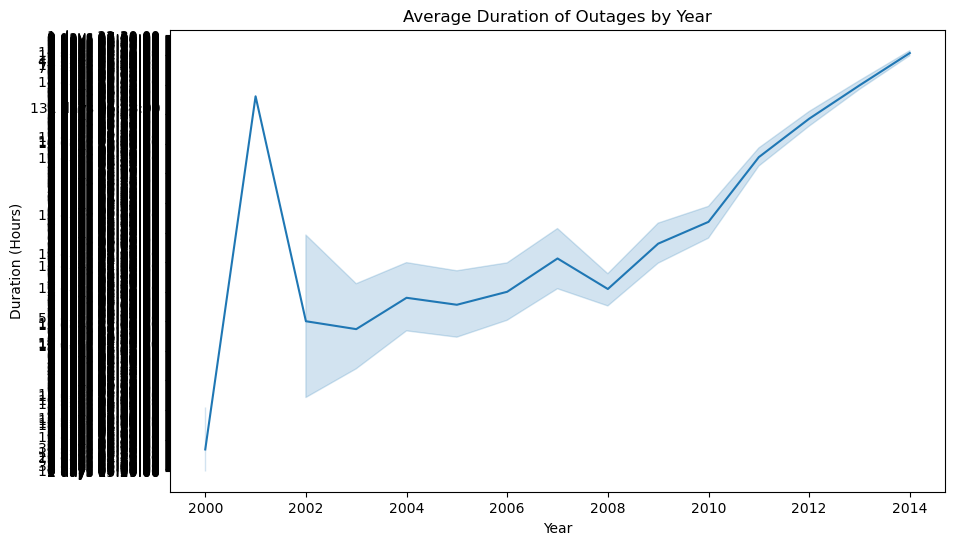

In [28]:
#Duration over time
plt.figure(figsize=(10,6))
sns.lineplot(x='Year', y='Duration', data=outage_df)
plt.title('Average Duration of Outages by Year')
plt.xlabel('Year')
plt.ylabel('Duration (Hours)')
plt.show()

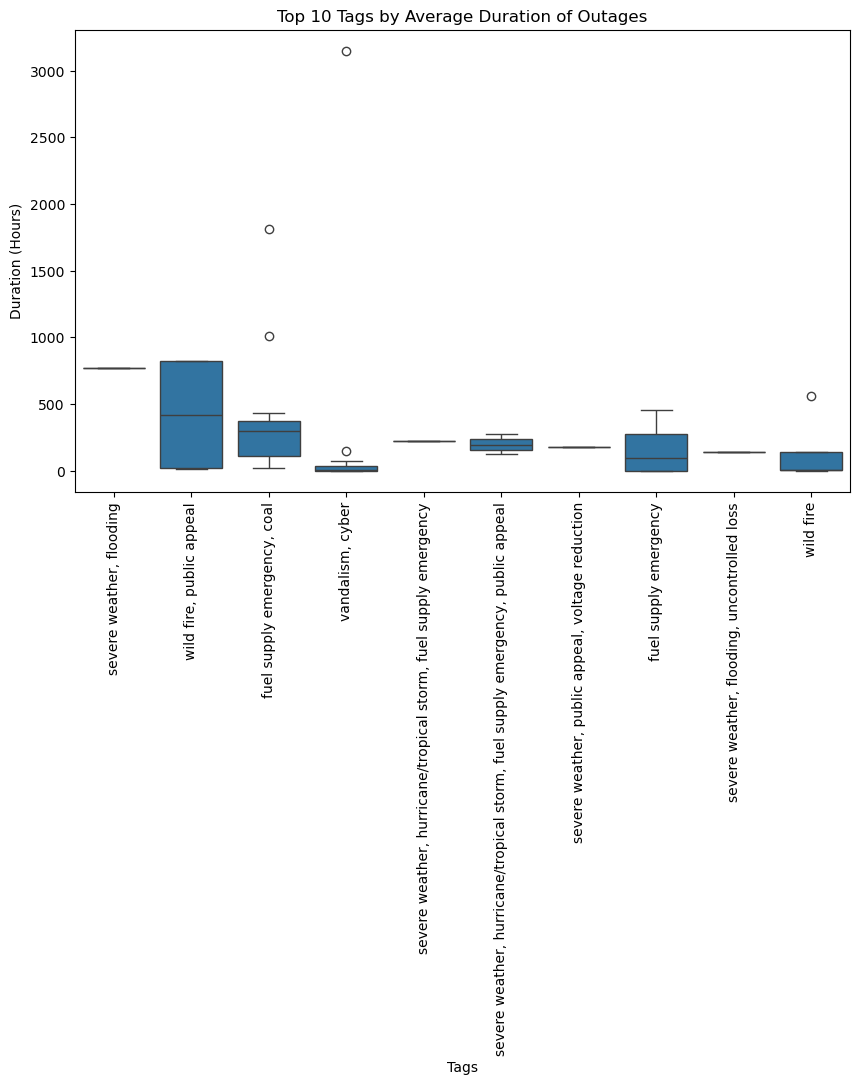

In [29]:
# Calculate the mean duration for each tag
top_10_tags_duration = outage_df.groupby('Tags')['Duration (Hours)'].mean().nlargest(10).index

# Filter the DataFrame to include only those tags
top_tags_duration_data = outage_df[outage_df['Tags'].isin(top_10_tags_duration)]

# Plot the duration of outages by tag (only the top 10 by average duration)
plt.figure(figsize=(10,6))
sns.boxplot(x='Tags', y='Duration (Hours)', data=top_tags_duration_data, order=top_10_tags_duration)
plt.title('Top 10 Tags by Average Duration of Outages')
plt.xlabel('Tags')
plt.ylabel('Duration (Hours)')
plt.xticks(rotation=90)
plt.show()


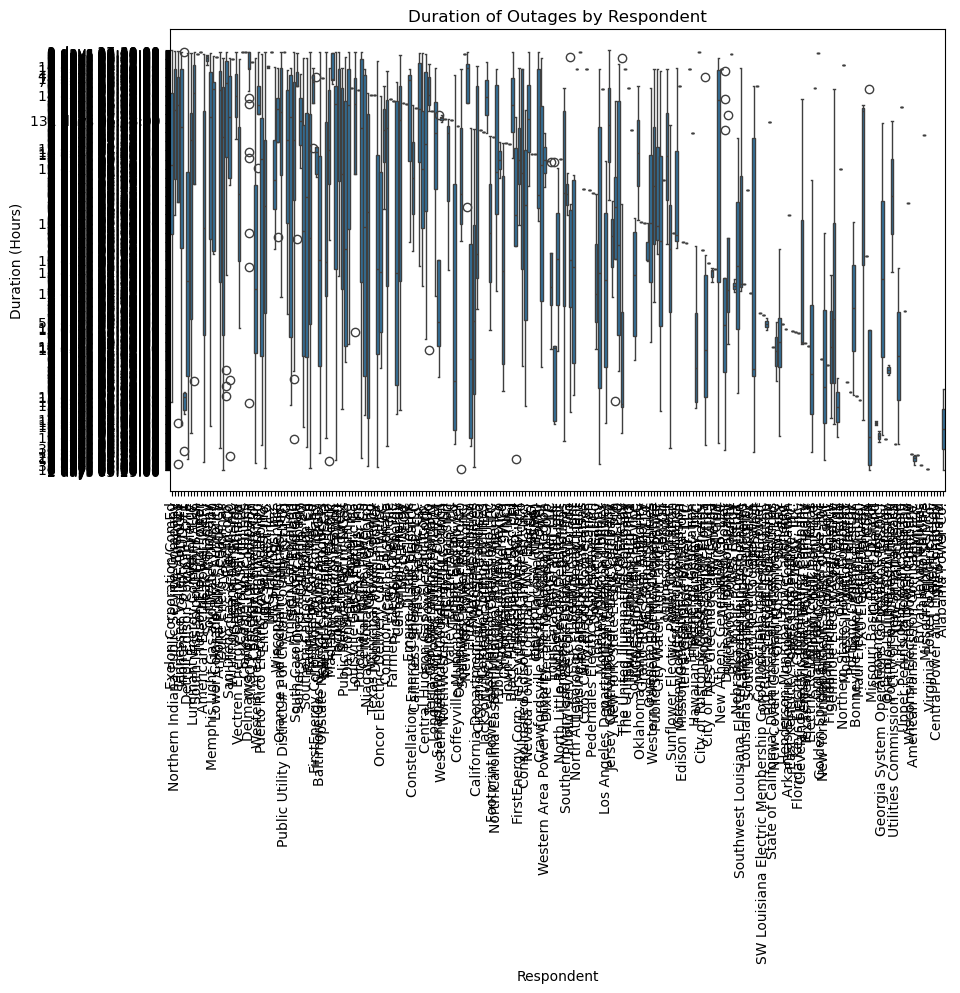

In [30]:
#Duration by respondent
plt.figure(figsize=(10,6))
sns.boxplot(x='Respondent', y='Duration', data=outage_df)
plt.title('Duration of Outages by Respondent')
plt.xlabel('Respondent')
plt.ylabel('Duration (Hours)')
plt.xticks(rotation=90)
plt.show()


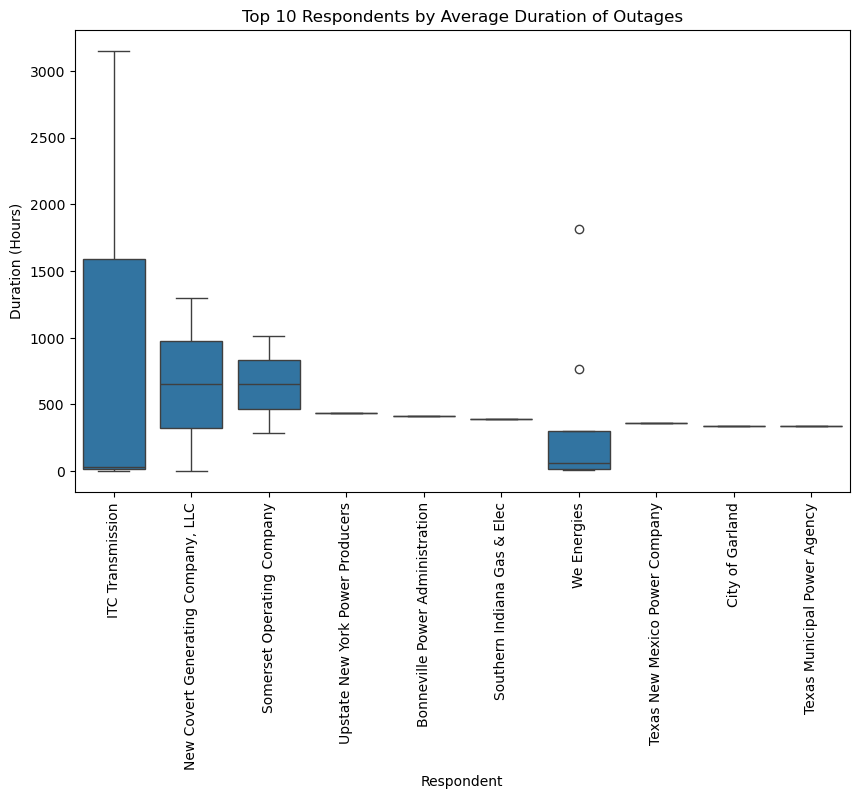

In [31]:
# Calculate the mean duration for each respondent
top_10_respondents_duration = outage_df.groupby('Respondent')['Duration (Hours)'].mean().nlargest(10).index

# Filter the DataFrame to include only those respondents
top_respondents_duration_data = outage_df[outage_df['Respondent'].isin(top_10_respondents_duration)]

# Plot the duration of outages by respondent (only the top 10 by average duration)
plt.figure(figsize=(10,6))
sns.boxplot(x='Respondent', y='Duration (Hours)', data=top_respondents_duration_data, order=top_10_respondents_duration)
plt.title('Top 10 Respondents by Average Duration of Outages')
plt.xlabel('Respondent')
plt.ylabel('Duration (Hours)')
plt.xticks(rotation=90)
plt.show()


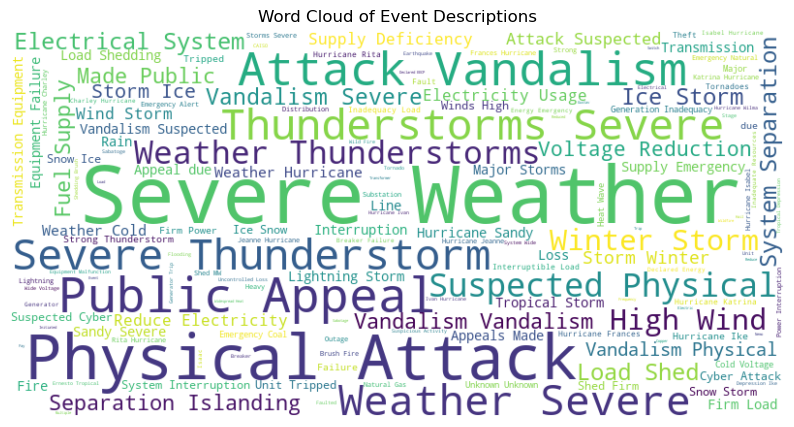

In [33]:
#Text analysis
from wordcloud import WordCloud

# Combine all descriptions into a single text
text = ' '.join(outage_df['Event Description'].dropna())

# Generate word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Event Descriptions')
plt.show()


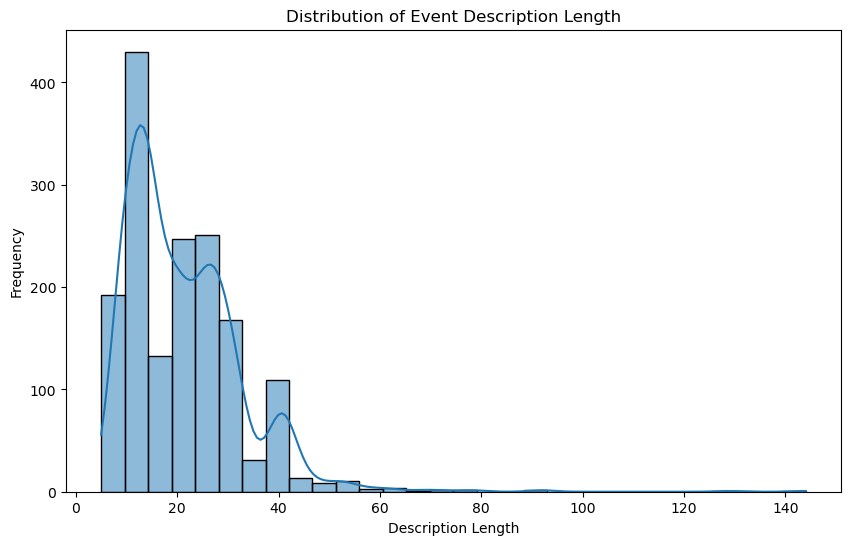

In [34]:
#text length analysis
# Length of event descriptions
outage_df['Description Length'] = outage_df['Event Description'].apply(lambda x: len(str(x)))

# Histogram of description length
plt.figure(figsize=(10, 6))
sns.histplot(outage_df['Description Length'], bins=30, kde=True)
plt.title('Distribution of Event Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()


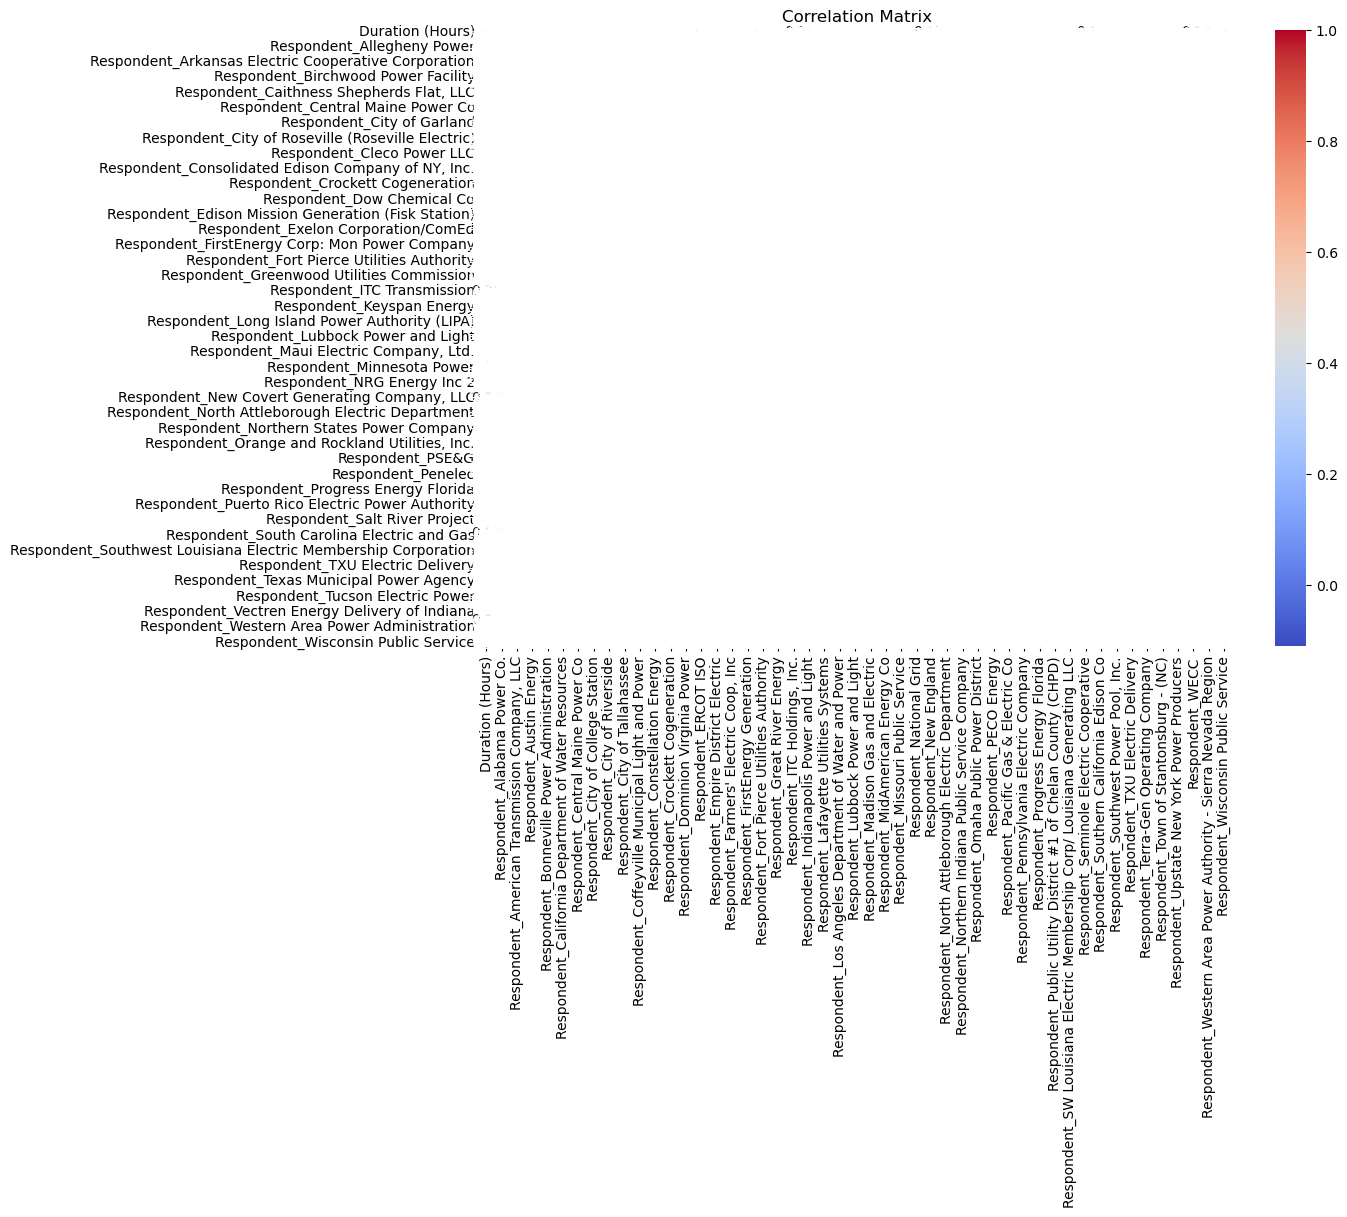

In [35]:
#correlation
# Convert categorical variables to numeric if needed
df_encoded = pd.get_dummies(outage_df[['Year', 'Respondent']], drop_first=True)

# Combine with Duration for correlation analysis
df_corr = pd.concat([outage_df[['Duration (Hours)']], df_encoded], axis=1)

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [37]:
#normalize/scale features
from sklearn.preprocessing import StandardScaler

# Scaling duration if necessary
scaler = StandardScaler()
outage_df['Duration (Hours)_scaled'] = scaler.fit_transform(outage_df[['Duration (Hours)']])


In [38]:
# Save the updated dataframe to a new CSV file
outage_df.to_csv('EDAoutagedata.csv', index=False)

In [37]:
pip install wordcloud


   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   ------------------------------------ --- 276.5/301.4 kB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
